In [60]:
%matplotlib inline

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt

# math and data manipulation
import numpy as np
import pandas as pd

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed

# Tensorflow
from tensorflow import keras 
import tensorflow as tf

# progress bar
from tqdm import tqdm

from csef.utils import performance
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data Loading

In [3]:
data_path = Path('..', '..', 'data', 'raw')
consumption_train = pd.read_csv(data_path / 'consumption_train.csv', 
                                index_col=0, parse_dates=['timestamp'])
cold_start_test = pd.read_csv(data_path / 'cold_start_test.csv', 
                              index_col=0, parse_dates=['timestamp'])
submission_format = pd.read_csv(data_path / 'submission_format.csv',
                                index_col='pred_id',
                                parse_dates=['timestamp'])

In [49]:
# fit a model
def model_build(config, loss='mean_absolute_error', optimizer='adam', stateful=True):
    n_input, n_nodes, n_batch = config

    # model parameters
    # n_batch should be 1 
    lag = n_input
    batch_input_shape=(n_batch, 1, lag)

    # instantiate a sequential model
    model = keras.Sequential()

    # add LSTM layer - stateful MUST be true here in 
    # order to learn the patterns within a series
    model.add(keras.layers.LSTM(units=n_nodes, 
                  batch_input_shape=batch_input_shape, 
                  stateful=stateful))

    # followed by a dense layer with a single output for regression
    model.add(keras.layers.Dense(1))

    # compile
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

def model_fit(model, train_df, config, train_col='consumption', group_col='series_id'):
    n_input, _, n_batch = config

    for ser_id, ser_data in train_df.groupby(group_col):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data[train_col], n_input)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()

    return model

# forecast with a pre-fit model
def model_predict(model, consumption, config, scaler, num_pred_hours=24, is_inverse_transform=True):
    n_input, _, _ = config
    
    # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
    X = scaler.transform(consumption.values.reshape(-1, 1))[-n_input:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, n_input), batch_size=1)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    if is_inverse_transform:
        hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).ravel()
    else:
        hourly_preds = preds_scaled

    return hourly_preds

In [74]:
def create_lagged_features(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['consumption'])
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.consumption.shift(i).pipe(_rename_lag, i))

    df.dropna(inplace=True)
    return df

def prepare_training_data(consumption_vals, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# walk-forward validation for univariate data
def walk_forward_validation(train, test, cfg, scaler, group_col='series_id'):
    errors = []
    
    # fit model
    model = model_build(cfg)
    model = model_fit(model, train_df, cfg)
        
    for ser_id, ser_data in test.groupby(group_col):
        yhat = model_predict(model, train[train.series_id == ser_id].consumption, cfg, scaler, is_inverse_transform=False)
        errors.append(measure_rmse(ser_data.consumption, yhat))
        model.reset_states()

    # estimate prediction error
    error = np.mean(errors)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(train, test, config, scaler, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(train, test, config, scaler) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
    plt.boxplot(scores)
    plt.show()

def sampling_data(df, frac=0.01):
    rng = np.random.RandomState(seed=RANDOM_SEED)
    series_ids = df.series_id.unique()
    series_mask = rng.binomial(1, frac, size=series_ids.shape).astype(bool)

    training_series = series_ids[series_mask]

    # reduce training data to series subset
    return df[df.series_id.isin(training_series)]

def train_test_split(df, n_test=24, group_col='series_id'):
    df = df.copy()
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for ser_id, ser_data in df.groupby(group_col):
        split_train, split_test = ser_data[:-n_test], ser_data[-n_test:]
        
        split_train[group_col] = ser_id
        split_test[group_col] = ser_id
        
        train_df = train_df.append(split_train)
        test_df = test_df.append(split_test)
    
    return train_df, test_df

def describe_training_data(train_df):
    num_training_series = train_df.series_id.nunique()
    num_training_days = num_training_series * 28
    num_training_hours = num_training_days * 24
    
    desc = f'There are {num_training_series} training ' \
           f'series totaling {num_training_days} days ' \
           f'({num_training_hours} hours) of consumption data.'
    
    print(desc)

In [6]:
samp_df = sampling_data(consumption_train)

In [10]:
describe_training_data(samp_df)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


## Training

In [18]:
# scale training data
scaler = MinMaxScaler(feature_range=(-1, 1))
samp_df['consumption'] = scaler.fit_transform(samp_df['consumption'].values.reshape(-1, 1))

/home/thuongdinh/.virtualenvs/mlcsef/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
samp_df['consumption'].head()

7392    0.494236
7393    0.589000
7394    0.615719
7395    0.592363
7396    0.600871
Name: consumption, dtype: float64

In [20]:
train_df, test_df = train_test_split(samp_df)

/home/thuongdinh/.virtualenvs/mlcsef/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/thuongdinh/.virtualenvs/mlcsef/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
describe_training_data(train_df)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


In [14]:
describe_training_data(test_df)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


In [25]:
config = [24, 24, 1]

In [70]:
scores = repeat_evaluate(train_df, test_df, config, scaler)

 > 0.291
 > 0.295
 > 0.284
 > 0.292
 > 0.287
 > 0.289
 > 0.293
 > 0.283
 > 0.289
 > 0.290
 > 0.301
 > 0.285
 > 0.288
 > 0.289
 > 0.291
 > 0.301
 > 0.296
 > 0.295
 > 0.297
 > 0.291
 > 0.297
 > 0.271
 > 0.294
 > 0.296
 > 0.287
 > 0.286
 > 0.296
 > 0.295
 > 0.294
 > 0.291


lstm: 0.291 RMSE (+/- 0.006)


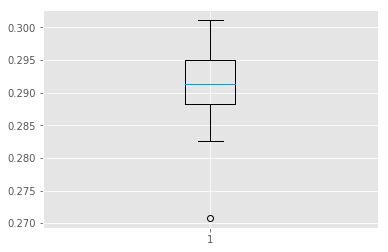

In [75]:
summarize_scores('lstm', scores)